In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from tqdm.notebook import tqdm

%matplotlib inline

warnings.filterwarnings('ignore')

In [7]:
# mounting folder from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
DATA_PATH_CLOUD = '/content/gdrive/MyDrive/DS/DFC/data/'

# Data Understanding

In [9]:
!ls -la $DATA_PATH_CLOUD

total 1270271
-rw------- 1 root root        318 May  3 14:12 categories.csv
-rw------- 1 root root 1107938448 Mar  8 10:15 data_fusion_train.parquet
-rw------- 1 root root    5370657 May  6 19:13 item_name_100k.txt
-rw------- 1 root root  181661438 May  6 19:13 item_name.txt
drwx------ 2 root root       4096 Apr 26 15:05 mlm1500000
drwx------ 2 root root       4096 Mar  8 10:26 Task1
drwx------ 2 root root       4096 Mar  8 10:26 Task2
-rw------- 1 root root    4013468 May  3 14:07 train_data.csv
-rw------- 1 root root    1759349 Mar 18 15:14 work_df.parquet.gzip


In [10]:
#using threads=False to open dataset with google colab bound
%%time
use_threads=False
df = pd.read_parquet(DATA_PATH_CLOUD + 'data_fusion_train.parquet')

CPU times: user 23.4 s, sys: 5.53 s, total: 28.9 s
Wall time: 39.1 s


In [11]:
df.shape

(26094077, 9)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26094077 entries, 0 to 45729315
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   receipt_id         int64  
 1   receipt_dayofweek  int32  
 2   receipt_time       object 
 3   item_name          object 
 4   item_quantity      float64
 5   item_price         int64  
 6   item_nds_rate      int32  
 7   category_id        int64  
 8   brands             object 
dtypes: float64(1), int32(2), int64(3), object(3)
memory usage: 1.7+ GB


In [13]:
df.head(10)

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
0,7,5,09:50,Флуконазол капс 150мг №1 Вертекс,1.0,7,-1,-1,вертекс
1,11,6,20:34,"Молоко 3,2%,шт",2.0,8,2,78,None
2,39,4,11:28,"Борщ Станичный с тушенкой, 103 ккал (завод, з/у)",1.0,6,1,-1,None
3,39,4,11:28,"Компот из изюма, 114 ккал",1.0,4,1,71,None
4,39,4,11:28,"Макаронные изделия отварные (масло сливочное),...",1.0,4,1,71,None
6,39,4,11:28,"Филе Горизонт (филе птицы), 218 ккал",1.0,7,1,-1,горизонт
10,49,3,14:27,3 Бумага Упак 1/Прочи/В асс,1.0,8,1,-1,None
11,49,3,14:27,4 Бумага Упак 1/Прочи/В асс,1.0,8,1,-1,None
12,49,3,14:27,Брюки спорт мал SAMO M-1016,1.0,13,6,-1,None
13,49,3,14:27,Бюстгальтер БН137,1.0,13,-1,-1,None


## Расшифровка колонок

In [14]:
df.columns

Index(['receipt_id', 'receipt_dayofweek', 'receipt_time', 'item_name',
       'item_quantity', 'item_price', 'item_nds_rate', 'category_id',
       'brands'],
      dtype='object')



*   receipt_id —  id чека;
*   receipt_dayofweek — день недели;
*   receipt_time — время создания чека;
*   item_name — наименование товара;
*   item_quantity — количество товара;
*   item_price — цена товара;
*   item_nds_rate — ставка НДС;
*   category_id — категория товара. 

















## Оптимизируем вес датасета

In [15]:
df.isnull().sum()

receipt_id                  0
receipt_dayofweek           0
receipt_time                0
item_name                   0
item_quantity               0
item_price                  0
item_nds_rate               0
category_id                 0
brands               19292769
dtype: int64

In [16]:
df['receipt_id'].describe()

count    2.609408e+07
mean     5.008370e+06
std      2.891319e+06
min      2.000000e+00
25%      2.505699e+06
50%      5.008298e+06
75%      7.511943e+06
max      1.001617e+07
Name: receipt_id, dtype: float64

In [17]:
df['category_id'].describe()

count    2.609408e+07
mean     2.537151e+01
std      5.376522e+01
min     -1.000000e+00
25%     -1.000000e+00
50%     -1.000000e+00
75%     -1.000000e+00
max      2.040000e+02
Name: category_id, dtype: float64

In [18]:
df['item_quantity'].describe()

count    2.609408e+07
mean     1.413864e+09
std      5.106975e+12
min      1.000000e-03
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.844674e+16
Name: item_quantity, dtype: float64

In [19]:
df['item_nds_rate'].describe()

count    2.609408e+07
mean     2.315496e+00
std      2.240315e+00
min     -1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      6.000000e+00
Name: item_nds_rate, dtype: float64

In [20]:
df['item_price'].describe()

count    2.609408e+07
mean     8.723268e+00
std      3.769641e+00
min      0.000000e+00
25%      6.000000e+00
50%      9.000000e+00
75%      1.100000e+01
max      4.200000e+01
Name: item_price, dtype: float64

In [21]:
df['receipt_dayofweek'].value_counts()

5    4209771
4    4012792
6    3648169
3    3606464
1    3572971
0    3556348
2    3487562
Name: receipt_dayofweek, dtype: int64

In [22]:
map_column_to_type = {
    'category_id': np.int16,
    'item_nds_rate': np.int16,
    'item_price': np.int16,
    'item_quantity': np.float32,
    'receipt_dayofweek': np.int16,
    'receipt_id': np.int32
}
for key in map_column_to_type:
    df[key] = df[key].astype(map_column_to_type[key])

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26094077 entries, 0 to 45729315
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   receipt_id         int32  
 1   receipt_dayofweek  int16  
 2   receipt_time       object 
 3   item_name          object 
 4   item_quantity      float32
 5   item_price         int16  
 6   item_nds_rate      int16  
 7   category_id        int16  
 8   brands             object 
dtypes: float32(1), int16(4), int32(1), object(3)
memory usage: 1.2+ GB


In [24]:
## оптимизация используемых типов данных - позволила сохранить ~500 МБ!!!

#Распределение категорий

In [25]:
pd.options.display.max_rows = 100
categories_count = df['category_id'].value_counts()
categories_count = categories_count.reset_index()
categories_count.columns = ['cat', 'count']

In [26]:
import matplotlib as mlp
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

warnings.filterwarnings(action='once')


In [27]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

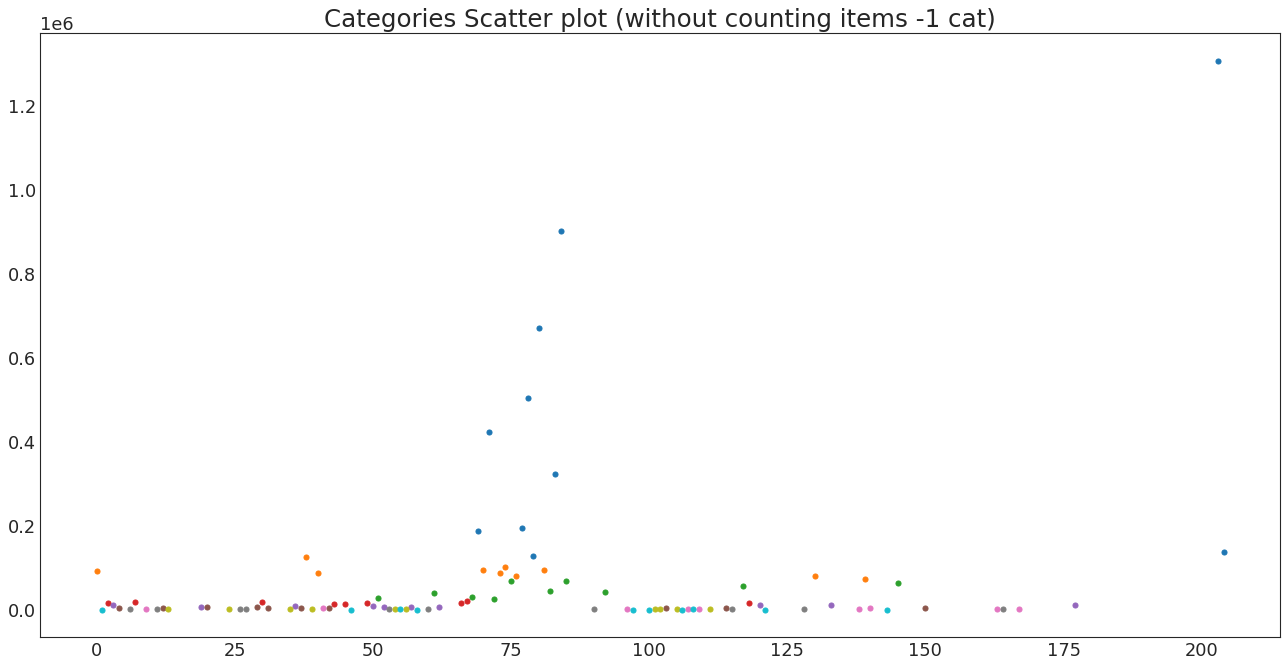

In [28]:

# Prepare Data 
# Create as many colors as there are unique midwest['category']
categories = categories_count[categories_count['cat'] != -1]['cat']
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Draw Plot for Each Category
plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')

for i, category in enumerate(categories):
    plt.scatter('cat', 'count', 
                data=categories_count[categories_count['cat'] != -1].loc[categories_count.cat==category, :],
                s=20, c=colors[i], label=str(category))

# Decorations
#plt.gca().set(xlim=(0.0, 205), ylim=(0, 900000))

#plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Categories Scatter plot (without counting items -1 cat)", fontsize=22)
#plt.legend(fontsize=12)    
plt.show() 

In [29]:
cats_brands_freq_df = pd.DataFrame(df[['brands', 'category_id']].dropna().value_counts().reset_index())
cats_brands_freq_df.columns = ['brands', 'category_id', 'item_count']

In [30]:
#cats_brands_freq_df.groupby('category_id').count()

In [31]:
%reload_ext google.colab.data_table
from google.colab import data_table
data_table.DataTable(cats_brands_freq_df.query('category_id != -1'), include_index=False, num_rows_per_page=10)

,brands,category_id,item_count
4,кока-кола,83,53406
14,орбит,84,26090
59,пепси,83,13449
84,пепси-кола,83,10945
112,вискас,145,9168
...,...,...,...
21096,русь,73,1
21101,пранафарм,38,1
21128,provoc,30,1
21132,kiabi,55,1


In [32]:
# топ 5 самых частых категорий
categories_count.head(20)

,cat,count
0,-1,19610851
1,203,1307260
2,84,902507
3,80,670833
4,78,503199
5,71,422085
6,83,322656
7,77,193369
8,69,186312
9,204,136271


In [33]:
#топ 5 самых редких категорий
categories_count.tail(20)

,cat,count
79,24,1149
80,13,801
81,105,741
82,56,690
83,101,626
84,111,612
85,39,507
86,35,480
87,102,459
88,54,456


In [34]:
df[df['category_id'] == -1].shape[0] - df[df['category_id'] == -1]['brands'].isnull().sum()

6156543

In [35]:
df.query("category_id == -1")['brands'].value_counts().head(100)

орбит              71904
кока-кола          69911
чудо               68404
aro                62998
пепси              46952
вискас             39457
фрутоняня          30177
приправыч          29052
провансаль         28183
святой источник    28148
дарницкий          27685
мираторг           26986
доширак            26644
слобода            24778
феликс             22326
лейс               21563
fine life          21557
от мартина         21370
лейз               20981
стм                20700
хайнц              20526
пепси-кола         20245
фруто няня         19938
бородинский        19538
махеевъ            19068
хохланд            18733
аленка             18672
сады придонья      18253
вкуснотеево        18237
даниссимо          18141
активиа            17911
one                17583
мистраль           17518
lays               17452
дирол              17383
мастер             17268
увелка             17033
нескафе            17002
rothmans           16981
хрустим            16763


#Чистка данных - ""Любая твоя ML модель хороша ровно настолько, насколько хороши твои данные""(пер. из какой-то статьи)

In [36]:
items_without_cat_count = df.shape[0] - df[df['category_id'] != -1].shape[0]
print(f'Общее число чеков: {df.shape[0]}')
print(f'Число чеков без категории: {items_without_cat_count}')
print(f'Число размечанных чеков: {df.shape[0] - items_without_cat_count}')

Общее число чеков: 26094077
Число чеков без категории: 19610851
Число размечанных чеков: 6483226


In [37]:
df[~df['brands'].isnull()]

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
0,7,5,09:50,Флуконазол капс 150мг №1 Вертекс,1.000,7,-1,-1,вертекс
6,39,4,11:28,"Филе Горизонт (филе птицы), 218 ккал",1.000,7,1,-1,горизонт
16,56,5,11:42,ЙогуртпитEPICAклуб/мар290,1.000,10,2,-1,epic
19,59,1,01:03,"Напиток Дюшес 0,65л ПЭТ ОАО""АЯН"" Респуб. Хак...",1.000,6,1,-1,аян
41,110,4,18:32,Чипсы Лейс сметана\лук 40гр,1.000,6,1,-1,лейс
...,...,...,...,...,...,...,...,...,...
45729288,10016153,1,22:20,"Ж/р Орбит Зимняя свеж. 13,6г.",1.000,6,6,-1,орбит
45729289,10016153,1,22:20,Конфеты желейные Золотая стрекоза 1кг КДВ,0.231,12,1,-1,стрекоза
45729296,10016153,1,22:20,Сыр Кабош Гауда Премиум 50% слайс 150г,1.000,11,2,-1,кабош
45729298,10016153,1,22:20,Чипсы Lays Соленые 150г,1.000,9,1,-1,lays


In [38]:
work_df = df[df['category_id'] != -1] # на данном этапе рассмотрим данные с размеченной категорией

In [39]:
work_df.shape

(6483226, 9)

### Проверим наличие дубликатов

In [40]:
work_df[work_df.duplicated()] #~35к полные дубликаты - от них можно сразу же избавиться

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
1891,3632,2,14:37,Пакет,1.000,2,1,203,None
7551,16222,3,10:44,КОКА-КОЛА СР. БКОМБО,1.000,9,1,83,кока-кола
7636,16342,4,16:37,Пакет,1.000,0,1,203,None
8871,19135,5,16:55,Пакет,3.000,4,1,203,None
9472,20496,0,12:35,Пакет,1.000,2,1,203,None
...,...,...,...,...,...,...,...,...,...
45726385,10009738,3,19:55,Пакет,1.000,0,1,203,None
45726550,10010150,4,21:26,Пакет,1.000,4,1,203,None
45726809,10010587,3,17:47,Пакет,1.000,2,1,203,None
45727775,10012920,4,18:45,Пакет,1.000,2,1,203,None


In [41]:
#проверим сколько дуликатов по item_name
work_df[work_df['item_name'].duplicated()]

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
150,356,2,13:07,Пакет,1.0,3,6,203,None
185,558,1,13:55,Пакет,1.0,3,6,203,None
195,562,5,15:29,Пакет,1.0,0,1,203,None
226,674,6,13:19,Пакет,1.0,2,6,203,None
491,1005,5,22:20,Пакет,1.0,3,1,203,None
...,...,...,...,...,...,...,...,...,...
45729256,10016106,6,12:18,Мороженое ЗОЛОТОЙ СТАНДАРТ рож,1.0,9,2,73,None
45729264,10016106,6,12:18,Пакет,1.0,3,1,203,None
45729277,10016136,6,17:08,Пакет,1.0,3,1,203,None
45729279,10016149,1,11:08,Печень по-строгановски,1.0,8,1,71,None


In [42]:
work_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6483226 entries, 1 to 45729281
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   receipt_id         int32  
 1   receipt_dayofweek  int16  
 2   receipt_time       object 
 3   item_name          object 
 4   item_quantity      float32
 5   item_price         int16  
 6   item_nds_rate      int16  
 7   category_id        int16  
 8   brands             object 
dtypes: float32(1), int16(4), int32(1), object(3)
memory usage: 296.8+ MB


In [43]:
#в https://github.com/exotol/data_fusion_vtb/ есть хорошая идея - как избавиться от дубликатов - создать "среднюю сущность"

In [44]:
def create_mean_entity(data, clean_from_item_name_duplicates=False):
  gr_item_name = data.groupby('item_name')
  data['mean_item_quantity'] = gr_item_name['item_quantity'].transform("mean")
  data['sum_item_quantity'] = gr_item_name['item_quantity'].transform("sum")
  data['std_item_quantity'] = gr_item_name['item_quantity'].transform("std")
  data['min_item_quantity'] = gr_item_name['item_quantity'].transform("min")
  data['max_item_quantity'] = gr_item_name['item_quantity'].transform("max")

  data['mean_item_price'] = gr_item_name['item_price'].transform("mean")
  data['sum_item_price'] = gr_item_name['item_price'].transform("sum")
  data['std_item_price'] = gr_item_name['item_price'].transform("std")
  data['min_item_price'] = gr_item_name['item_price'].transform("min")
  data['max_item_price'] = gr_item_name['item_price'].transform("max")

  data['mean_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("mean")
  data['sum_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("sum")
  data['std_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("std")
  data['min_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("min")
  data['max_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("max")


  data['hours'] = data['receipt_time'].apply(lambda x: int(x.split(":")[0]))

  data['mean_hours'] = gr_item_name['hours'].transform("mean")
  data['sum_hours'] = gr_item_name['hours'].transform("sum")
  data['std_hours'] = gr_item_name['hours'].transform("std")
  data['min_hours'] = gr_item_name['hours'].transform("min")
  data['max_hours'] = gr_item_name['hours'].transform("max")


  data['median_dayofweek'] = gr_item_name['receipt_dayofweek'].transform('median')
  data['median_dayofweek'] = data['median_dayofweek'].astype(np.int8)

  return clean_from_duplicates(data) if clean_from_item_name_duplicates else data

def clean_from_duplicates(data):
  return data.drop_duplicates('item_name')


In [45]:
clean_df = create_mean_entity(work_df, clean_from_item_name_duplicates=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48225 entries, 1 to 45700308
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   receipt_id          48225 non-null  int32  
 1   receipt_dayofweek   48225 non-null  int16  
 2   receipt_time        48225 non-null  object 
 3   item_name           48225 non-null  object 
 4   item_quantity       48225 non-null  float32
 5   item_price          48225 non-null  int16  
 6   item_nds_rate       48225 non-null  int16  
 7   category_id         48225 non-null  int16  
 8   brands              7409 non-null   object 
 9   mean_item_quantity  48225 non-null  float32
 10  sum_item_quantity   48225 non-null  float32
 11  std_item_quantity   40093 non-null  float64
 12  min_item_quantity   48225 non-null  float32
 13  max_item_quantity   48225 non-null  float32
 14  mean_item_price     48225 non-null  float64
 15  sum_item_price      48225 non-null  float64
 16  s

# WordClouds - посмотрим на самые важные классы(категории)

In [47]:
!pip install wordcloud

In [48]:
%unload_ext google.colab.data_table
categories_count.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98
cat,-1,203,84,80,78,71,83,77,69,204,79,38,74,70,81,0,40,73,130,76,139,75,85,145,117,82,92,61,68,51,72,67,7,30,66,49,2,118,45,43,...,103,140,41,9,138,96,107,167,163,109,128,6,27,115,53,90,26,11,164,60,24,13,105,56,101,111,39,35,102,54,55,108,58,100,1,106,97,46,143,121
count,19610851,1307260,902507,670833,503199,422085,322656,193369,186312,136271,126837,126410,101648,94482,93440,92280,88427,88121,80566,80476,71907,69004,67961,64365,55324,45508,41629,39821,30077,26690,24865,21723,17756,17168,16823,16274,15502,15353,14597,14362,...,3695,3252,2871,2569,2565,2443,2377,2064,2042,1988,1914,1814,1787,1710,1646,1642,1470,1435,1388,1158,1149,801,741,690,626,612,507,480,459,456,444,406,356,312,226,183,109,67,25,1


In [49]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

/usr/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/lib/python3.7/dist-packages/wordcloud/wordcloud.py:30: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


In [50]:
def get_text_all_category(data, category_id):
    text = " "
    category = data[data.category_id == category_id]
    for idx, row in tqdm(category.iterrows(), total=category.shape[0]):
        text += row['item_name'] + " "
    return text

def plot_category(data, category_id, figsize=(7, 5)):
    plt.figure(figsize=figsize)
    category = get_text_all_category(data, category_id)
    wordcloud = WordCloud(max_font_size=40).generate(category)
    print(f'Category: {category_id}')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [51]:
most_freq_cats_list = categories_count['cat'].loc[1:6] # не считая -1
least_freq_cats_list = categories_count['cat'].iloc[93:-1]

In [52]:
most_freq_cats_list

1    203
2     84
3     80
4     78
5     71
6     83
Name: cat, dtype: int64

In [53]:
least_freq_cats_list# the last one have no words in item names

93      1
94    106
95     97
96     46
97    143
Name: cat, dtype: int64

## Посмотрим на 5 самых частых категорий




Category: 203


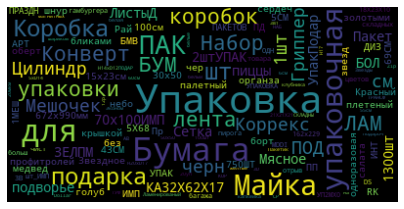


Category: 84


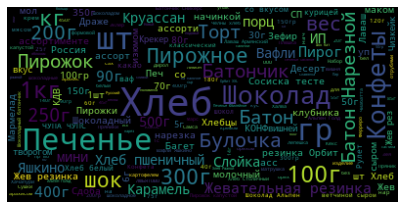


Category: 80


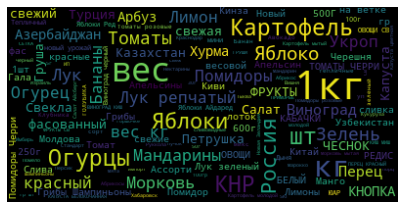


Category: 78


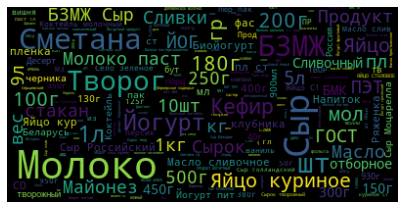


Category: 71


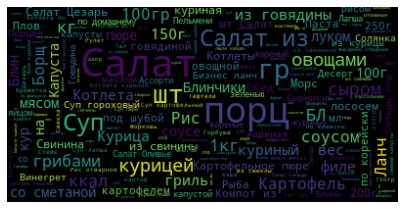


Category: 83


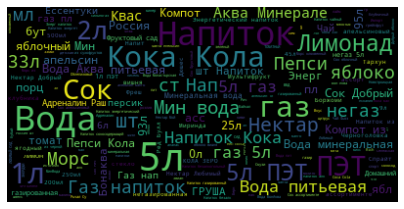

In [54]:
for cat in most_freq_cats_list:
  plot_category(clean_df, cat)

## Посмотрим на 5 самых редких категорий

In [55]:
categories_count.tail(7)['cat'].values[:-2]

array([100,   1, 106,  97,  46])


Category: 100


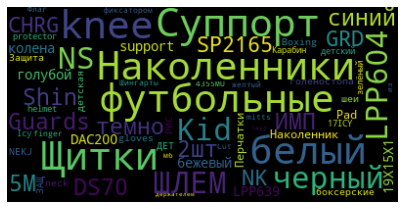


Category: 1


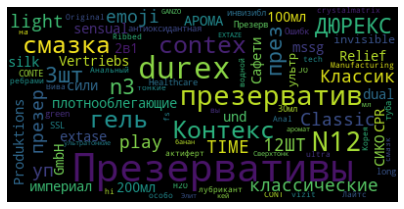


Category: 106


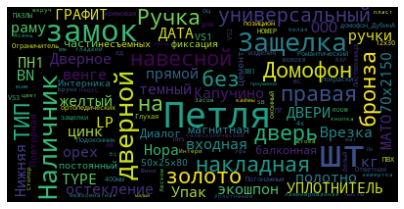


Category: 97


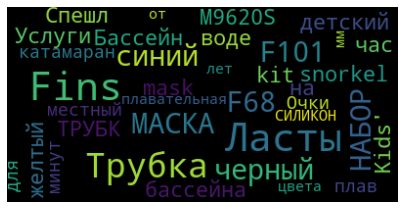


Category: 46


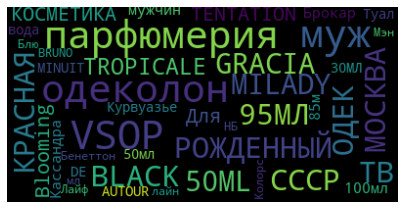

In [56]:
for cat in categories_count.tail(7)['cat'].values[:-2]:
  plot_category(clean_df, cat) # last one dont words??